In [1]:
# install for AWS
!pip install torch
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install matplotlib
!pip install torchvision
!pip install s3fs
!pip install boto3
!pip install tqdm
# !pip install fiftyone

DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standa

In [2]:
import os
import torch
import tarfile
import shutil
import torchvision
import random
import warnings
import boto3
import s3fs
import io
import time
import botocore.exceptions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets
from io import BytesIO
from torch import nn, optim
from tqdm import tqdm

warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# import fiftyone as fo
# import fiftyone.brain as fob
# import fiftyone.zoo as foz
# from fiftyone import ViewField as F

# Define Hyperparams

In [3]:
batch_size = 32
learning_rate = 0.001
fine_tune_learning_rate = learning_rate / 10
num_classes = 52
num_epochs = 2
fine_tune_epochs = 2
disparity_weight = 0.1
alpha = 0.5
temperature = 5.0

# Load, Transform, and Split Data

In [4]:
# Initialize S3 client
s3_client = boto3.client('s3', region_name='us-west-2')

In [5]:
# Define the S3 bucket name and prefixes
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

In [6]:
# Load CSV annotations from S3
annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}annotations.csv'
df = pd.read_csv(annotations_s3_path)

In [7]:
# Extracting unique class labels from the 'class1' column
classes = df['class1'].unique()

# Creating a mapping from index to class label
idx_to_class = {i: j for i, j in enumerate(classes)}

# Creating a reverse mapping from class label to index
class_to_idx = {value: key for key, value in idx_to_class.items()}

# Creating a mapping from index to annotation column name starting from the 7th column
idx_to_annot = {i: j for i, j in enumerate(df.columns[6:])}


In [8]:
# # check count of jpg files
# def count_jpg_files(bucket_name, prefix=''):
#     """
#     Count the number of .jpg files in an S3 bucket under a given prefix.
    
#     Parameters:
#     - bucket_name (str): Name of the S3 bucket.
#     - prefix (str): Prefix path to filter results. Default is empty.
    
#     Returns:
#     - count (int): Count of .jpg files.
#     """
#     count = 0
#     paginator = s3_client.get_paginator('list_objects_v2')
    
#     for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
#         for obj in page.get('Contents', []):
#             if obj['Key'].endswith('.jpg'):
#                 count += 1

#     return count

# # Count .jpg files in the 'w210facetdata' bucket under the 'images/' prefix
# jpg_count = count_jpg_files(bucket_name, images_prefix)
# print(f"Number of .jpg files in the '{bucket_name}/{images_prefix}' path: {jpg_count}")


In [9]:
# df.iloc[0][6:]

In [10]:
# idx_to_class

In [11]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [12]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)


In [13]:
# toggle on/off subsetting
# Define the number of samples you want in your subset
subset_size = 200  # Adjust the size as needed

# Create a smaller subset of your dataset
train_data = train_data[:subset_size]
test_data = test_data[:subset_size]
val_data = val_data[:subset_size]

In [14]:
# Define additional metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Lists to store metric values during training
train_losses_student, val_losses_student, train_losses_teacher, val_losses_teacher = [], [], [], []
train_accuracies_student, val_accuracies_student, train_accuracies_teacher, val_accuracies_teacher = [], [], [], []


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class CustomDataset(Dataset):
    def __init__(self, split_data, image_dir, transform=None):
        self.data = split_data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 2]
        image_key = f'{images_prefix}{img_name}'  # Construct S3 object key
        # Load image from S3
        img_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        img_data = img_object['Body'].read()
        # Open the image directly from the byte stream using PIL
        image = Image.open(BytesIO(img_data))
        annotations = self.data.iloc[idx, 6:].values.astype(np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Create custom datasets and data loaders
image_dir = 'FACET'  # Local directory if you want to save images locally
train_dataset = CustomDataset(split_data=train_data, image_dir=image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(split_data=test_data, image_dir=image_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(split_data=val_data, image_dir=image_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# fig = plt.figure()

# for i, sample in enumerate(train_dataset):
#     ax = plt.subplot(1, 4, i + 1)
#     plt.imshow(np.transpose(sample[0], [1,2,0]))
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     plt.show()
#     if i == 3:
#         break


# Model

In [18]:
# device = torch.device('mps')

# Define your smaller ResNet student model
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=52):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(131072, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=52):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(65536, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define loss functions
criterion_teacher = nn.CrossEntropyLoss()  # Loss for teacher model
criterion_student = nn.KLDivLoss()  # Knowledge distillation loss

# Instantiate the teacher and student models
teacher_model = torchvision.models.resnet50(pretrained=True)
num_ftrs = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs, num_classes)
teacher_model = teacher_model.to(device)

student_model = LightNN(num_classes=num_classes).to(device)

# Load pre-trained weights if available
pretrained_path = 'pretrained_student.pth'
if os.path.exists(pretrained_path):
    student_model.load_state_dict(torch.load(pretrained_path))
    print("Loaded pre-trained weights for student model.")

# Define optimizer for the student model
optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=learning_rate)


# Train


In [19]:
# Define attributes and concepts in your dataset
attributes = df.columns[6:].tolist()  # All attributes
concepts = list(idx_to_class.values())  # All concepts

# Create a dictionary to map attribute names to column indices
attr_idx = {attr: idx for idx, attr in enumerate(attributes)}

# Initialize dictionaries to store recall values for teacher and student models
teacher_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}
student_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}


Epoch 1/4:  14%|██████████▋                                                                | 1/7 [00:14<01:28, 14.74s/it]

KD Loss: 4.8045108997030184e-05
CE Loss: 3.943774700164795
Disparity Loss: 0.7031265497207642
Total Loss: 2.6750378608703613
teacher_recall: 0.03125, student_recall: 0.0
Labels: [ 4  4 16 21 19 43 46 40 26 11 26 28 18 36  9 22 26 21 35  9  4  9 11 39
 41 43  4 33 11 36 22 32]
Student Predictions: [20 13 13 39 39 13 13 13  6 13  7 13 13 39 39 39 11 13 13 39 13 46 39 11
 39 13 11 46 50 26 11 39]
Teacher Predictions: [12 12 12 12 12 12  9 12  9 12 33 12 12  9 12 12 12 34  9  9 12 12 12  9
 12 38 12 12 12  9 44 33]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[-0.0087, -0.0753,  0.1364,  ..., -0.1204,  0.0547, -0.1553],
        [-0.1038, -0.0194,  0.0613,  ..., -0.0053,  0.0672,  0.0117],
        [-0.0396,  0.0311,  0.0434,  ..., -0.0614,  0.0604,  0.0893],
        ...,
        [-0.1148, -0.0405,  0.0850,  ..., -0.0676,  0.1122,  0.0058],
        [-0.0268,  0.0029,  0.0343,  ..., -0.0177,  0.0576, -0.0045],
        [ 0.0338,  0.0356,  0.0285,  ..., -0.03

Epoch 1/4:  29%|█████████████████████▍                                                     | 2/7 [00:29<01:12, 14.55s/it]

KD Loss: 0.01637931726872921
CE Loss: 16.64425277709961
Disparity Loss: 0.06875000149011612
Total Loss: 8.399065971374512
teacher_recall: 0.03125, student_recall: 0.0
Labels: [19 44 14  1 10 23 11 17  1  4 23 19 33  3 44 40 45 19 23 19  1  4 21 23
 36 36 28 20 22 11  3 22]
Student Predictions: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Teacher Predictions: [39  2 39 27  7 39 19 39  2 39 20 32 41 20 19 36 27 36  6  2 35  7  7  2
 35 32 32  2 39 32  3 35]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[-3.4796,  2.0016, -8.0813,  ..., -4.0039, -0.4557, -5.2651],
        [-3.9286,  2.2271, -7.1740,  ..., -2.7751, -0.5313, -5.1530],
        [-1.2919,  0.9835, -4.2850,  ..., -4.7626, -1.0998, -6.6628],
        ...,
        [-2.6658,  1.2120, -6.3291,  ..., -4.6543,  2.1731, -7.0539],
        [-3.8223,  5.5671, -9.3505,  ..., -7.6584,  0.7012, -8.5365],
        [-1.6871,  0.3130, -7.2968,  ..., -3.4843,  0.6968, -5.1524]],
       grad_

Epoch 1/4:  43%|████████████████████████████████▏                                          | 3/7 [00:45<01:00, 15.17s/it]

KD Loss: 0.009622974321246147
CE Loss: 12.792064666748047
Disparity Loss: -0.5479176640510559
Total Loss: 5.852925777435303
teacher_recall: 0.0, student_recall: 0.03125
Labels: [ 1  1 16 11  4 40  0 15  6  7 41 50  5  4 11  9  5 35  4 11  8  3  3  8
 40 18 31 22  4 15 44 15]
Student Predictions: [11 22 11 22 22 11 22 11 11 11  9 22 11 11 22 32  9 22 22 22 11 11 22 22
 22 11 11 22 11 11 22 22]
Teacher Predictions: [43 39 39 42 19 20 32 39 43 32 20 41 39 32 39 32 39  4 39 19 39 19 20 21
 39 39 42 43 39  4 39 39]
attr_indices: [4 7]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ -1.9104,   0.6212,  -6.7290,  ...,  -3.8736,   3.6517, -10.2192],
        [ -1.9627,   2.3645,  -4.7028,  ...,  -4.7433,   1.4917,  -5.6612],
        [ -1.7055,   3.6067,  -5.1514,  ...,  -4.8915,   0.6942,  -6.1263],
        ...,
        [ -2.1080,   1.3253,  -3.9527,  ...,  -3.1428,   1.7306,  -5.1863],
        [ -3.5483,   1.7789,  -5.7484,  ...,  -3.0111,   3.1129,  -7.2330],
        [ -0.20

Epoch 1/4:  57%|██████████████████████████████████████████▊                                | 4/7 [01:00<00:45, 15.21s/it]

KD Loss: 0.005649450700730085
CE Loss: 12.065696716308594
Disparity Loss: -0.9135435819625854
Total Loss: 5.122129440307617
teacher_recall: 0.0, student_recall: 0.03125
Labels: [ 5  5 21 20 19 27 17 44 44  6 23 49 14 37 15  8  9  4  4  1  6  4  4  4
 15  1 24 44  3  4  3  9]
Student Predictions: [32 40  9  9 36 40 40 40 40 36 36 36 36 36 40 36  9 40 46  9 40 46 18 36
 36 36 40 36  9  9 40 40]
Teacher Predictions: [41 32 19 19 42 41 32 39 39 39 39 32 39 39 42 39 19 32 43 19 39 32 39 41
 39 19 19 39 39 19 42 19]
attr_indices: [14]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 1.1862,  2.8755, -2.7233,  ..., -4.8619,  3.1447, -5.2584],
        [ 2.7603,  2.4502, -4.4115,  ..., -3.3302,  0.1822, -5.3255],
        [-0.8072,  4.3772, -3.9213,  ..., -4.3412,  3.0672, -4.2296],
        ...,
        [ 1.2878,  4.0931, -2.0372,  ..., -2.8283, -1.4297, -2.4155],
        [ 0.7335,  3.0675, -3.6384,  ..., -4.9678, -1.1075, -5.8872],
        [ 1.3800,  3.4740, -3.8453,  ..., -3.7

Epoch 1/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [01:13<00:29, 14.62s/it]

KD Loss: 0.003198498161509633
CE Loss: 8.889752388000488
Disparity Loss: -0.40114638209342957
Total Loss: 4.0453290939331055
teacher_recall: 0.0, student_recall: 0.03125
Labels: [ 1 21 26 40  6  4  3 36  5 31  1  4 42  1 16  4  4  5 35  4 35 28  2 18
 22 14  4 10 26 19  1 36]
Student Predictions: [44 40 18  9 40 44 40  8 44 44 40 44 36 40  8 32 40  8 41 32 44 40 40  1
 40 32 44 32 44 44 44  8]
Teacher Predictions: [19 36 36 42 36 32 19 39 39 19 19 32 43 32 39 39 39 32 19 39 19 36 32 39
 19 19 41 39 39 39 32 36]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.6527,  2.1059, -2.5895,  ..., -0.9736,  1.4665, -3.3213],
        [ 1.0240,  2.6719, -0.3395,  ...,  0.1558, -0.4403, -1.5618],
        [ 0.0553,  4.2338, -1.7324,  ..., -1.0661,  1.9033, -2.3742],
        ...,
        [-0.4682,  3.1057,  0.7521,  ..., -1.7804,  1.6675, -3.9914],
        [ 0.7478,  2.2529, -1.6893,  ..., -0.5781,  0.6344, -2.6687],
        [ 1.7078,  1.4661, -2.3309,  ..., -2.12

Epoch 1/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [01:27<00:14, 14.36s/it]

KD Loss: 0.002669369336217642
CE Loss: 8.025347709655762
Disparity Loss: -0.8463558554649353
Total Loss: 3.1676526069641113
teacher_recall: 0.0, student_recall: 0.03125
Labels: [ 7 23  3 28  1 31 35  6 28 30  4  3  4 37 48  4 30 22 41 13  5 37 17 20
 16 20 10 30 50 33  8  4]
Student Predictions: [ 3 40  3 19  3  3 19 19  3 19  3  8 18 19 19  3 19 44 40  3 44  3 19 19
 44 40  0  8 19  8 44  8]
Teacher Predictions: [19 32 39 19 32 39 19 19 32 39 36 32 39 19 36 19 32 32 32 36 32 19 19 19
 19 19 36 43 39 39 36 19]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 1.5917,  3.2362, -1.4790,  ..., -1.1057,  1.2228, -2.5823],
        [ 1.9972,  3.9069,  0.0182,  ..., -0.5457,  1.9967, -3.0835],
        [ 0.7861,  2.1011, -1.8546,  ..., -2.0220,  1.3903, -2.6402],
        ...,
        [ 2.3449,  2.0213, -1.1020,  ..., -1.8699, -0.4884, -1.0209],
        [ 0.3125,  4.2916, -0.6508,  ..., -0.3940,  0.9324, -3.4790],
        [ 2.2658,  3.4709, -0.4215,  ..., -1.659

Epoch 1/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [01:30<00:00, 13.00s/it]


KD Loss: 0.002539766486734152
CE Loss: 4.820580005645752
Disparity Loss: -1.1229766607284546
Total Loss: 1.2885831594467163
teacher_recall: 0.0, student_recall: 0.03125
Labels: [15  8  8  4 14 44  1  1]
Student Predictions: [ 3  1  1  3  3 18  1  3]
Teacher Predictions: [36 19 19 19 41 19 19 19]
attr_indices: [6]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 3.7904e-01,  3.3329e+00,  4.0829e-01,  3.8484e+00, -9.3772e+00,
          4.2373e-01,  9.6453e-01, -3.5233e+00,  2.4795e+00, -1.4823e+00,
          1.7353e+00, -4.5423e-01, -2.0885e+00, -1.1403e+00,  2.5774e+00,
          2.0153e+00, -1.3283e+00, -1.0439e+00,  3.2418e+00,  3.0034e+00,
          2.7183e+00,  1.1228e+00, -1.1193e+00, -8.6041e-01, -2.8951e+00,
         -2.2811e-01,  1.7059e+00, -1.8615e+00,  1.8386e+00, -3.3457e+00,
         -1.9450e+00,  2.6628e+00,  1.9796e+00,  1.1596e+00, -1.3718e+00,
          7.9903e-01,  1.1658e+00,  2.4844e-01, -3.8891e+00, -4.4491e-01,
          1.2795e+00,  2.4454e+00,  1

Epoch 2/4:  14%|██████████▋                                                                | 1/7 [00:12<01:17, 12.95s/it]

KD Loss: 0.0020644827745854855
CE Loss: 5.048567771911621
Disparity Loss: -1.498631477355957
Total Loss: 1.0266847610473633
teacher_recall: 0.0, student_recall: 0.03125
Labels: [22 17  8  4 36 44 40 22  9 11 16 44 37 14  3  3 36  9  3 14  8  4 21  4
 28 37  6  1 30  5  4 35]
Student Predictions: [ 3  3 26  1  1  1 44  1 33  1 31 19  1  1  1  3 19  1 28  1  6  1 28  1
 28  1  1  1 19  3  1  1]
Teacher Predictions: [19 32 19 19 36 19 36 19 32 19 36 19 19 36 19 19 19 19 19 19 36 36 19 36
 19 19 19 19 36 19 19 19]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.4755,  3.3145, -0.1112,  ..., -1.2238,  0.6342, -2.2844],
        [ 0.7634,  2.9266,  0.0620,  ..., -0.8467,  1.5389, -0.9315],
        [ 0.4567,  2.5331,  1.2925,  ...,  0.8816,  1.4465, -1.5058],
        ...,
        [ 0.3044,  2.4362, -0.7204,  ..., -0.2934,  1.2260, -0.4193],
        [-0.5515,  4.8959, -0.5191,  ...,  1.2889,  1.9728, -1.7481],
        [ 0.0803,  3.1613,  1.7685,  ...,  1.230

Epoch 2/4:  29%|█████████████████████▍                                                     | 2/7 [00:25<01:04, 12.87s/it]

KD Loss: 0.0011429565493017435
CE Loss: 4.741912364959717
Disparity Loss: -2.103167772293091
Total Loss: 0.268359899520874
teacher_recall: 0.0, student_recall: 0.03125
Labels: [ 3 35  0 11 23  6 26  4  1 19 44  1 40 49  3 28  9  4 19  5  4 33 21  4
 16 31 45  4  4 18 14  1]
Student Predictions: [ 3  1  1  1  1  1 31  1  1 19  1  1  1  1 20  1  3  1  1  1  1  6  3  1
  3  1  1  1  3  1  1  1]
Teacher Predictions: [19 36 19 19 19 19 19 19 36 19 19 19 19 36 19 19 19 19 19 19 19 19 19 19
 19 19 19 36 19 36 36 19]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 1.0471,  2.2351,  0.4300,  ..., -0.6304,  0.5823, -1.5727],
        [ 0.9337,  2.6355, -0.3657,  ..., -0.3623,  0.5060, -1.0129],
        [ 2.0146,  3.8164, -0.1996,  ..., -0.4226,  1.1373, -0.9601],
        ...,
        [ 1.5344,  3.0113,  0.3611,  ..., -0.8467,  0.4241, -0.9521],
        [ 1.1904,  2.9197,  0.0312,  ..., -0.9935,  0.7234, -0.8523],
        [ 1.5034,  4.3432, -0.5815,  ...,  0.0243

Epoch 2/4:  43%|████████████████████████████████▏                                          | 3/7 [00:39<00:53, 13.28s/it]

KD Loss: 0.0007767825154587626
CE Loss: 4.613318920135498
Disparity Loss: -2.295210599899292
Total Loss: 0.011837244033813477
teacher_recall: 0.0, student_recall: 0.03125
Labels: [26  5  3  4 15 43 44  8  7  4  5 16  5  3 22 22 42 41 14 32  4 40 18 10
  9 17 36  4 39  4  4  9]
Student Predictions: [ 3  1 44  1  1  8  1  1  1  1  1 19  1 44 14  1  1  1 14  1 14  1  1  8
  1 35 33 15 44  1  1  1]
Teacher Predictions: [ 1  1 19  1  1  1  1  1  1 19  1  1 19 19  1  1  1  1  1  1  1 19  1  1
 19 19 19  1  1  1  1  1]
attr_indices: [29]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 1.7563e+00,  3.8706e+00,  4.2951e-02,  ..., -2.3213e+00,
          1.4920e+00, -2.1958e+00],
        [ 5.7157e-01,  1.9063e+00, -3.5886e-01,  ..., -2.9711e-01,
          6.5292e-01, -5.9383e-01],
        [ 9.8019e-04,  1.7834e+00, -4.4824e-01,  ...,  6.0173e-01,
          9.4130e-02, -6.2259e-01],
        ...,
        [ 8.6421e-01,  1.8661e+00,  1.4196e-01,  ..., -5.7930e-02,
          8.4059e-

Epoch 2/4:  57%|██████████████████████████████████████████▊                                | 4/7 [00:53<00:40, 13.54s/it]

KD Loss: 0.000494078965857625
CE Loss: 4.1373443603515625
Disparity Loss: -2.115318775177002
Total Loss: -0.046399593353271484
teacher_recall: 0.0, student_recall: 0.03125
Labels: [11 50 11 11 27  4 44 36 15 30  9 19 28  4  4 11  8 43 23 20 36 44 24  1
 17  1 19 41 31 35  4  5]
Student Predictions: [ 1 15  6  6 44 14 31  6 44 35  1  8  1  1 35 35 15 44  1 14  8  5  6  6
  1  1  5 14 44  6 35  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 1.0215,  2.2265, -0.2793,  ..., -0.1612,  0.2053, -0.8289],
        [ 0.6349,  1.5290, -0.2631,  ..., -0.1308, -0.1983, -0.3641],
        [ 1.2120,  1.1068, -0.2124,  ..., -0.6799, -0.5292, -0.2558],
        ...,
        [ 0.7938,  1.2367, -0.0047,  ..., -0.1688, -0.0240, -0.6005],
        [ 0.0611,  1.5139, -0.0641,  ...,  0.2832,  0.2647, -0.7835],
        [ 0.7914,  1.9444, -0.5522,  ...,  0.0460,  0.4330, -0.7364]],
       

Epoch 2/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [01:06<00:27, 13.51s/it]

KD Loss: 0.000456479872809723
CE Loss: 4.005975723266602
Disparity Loss: -1.4284582138061523
Total Loss: 0.5747578144073486
teacher_recall: 0.041666666666666664, student_recall: 0.03125
Labels: [40  4 23  4 10  1 15  4  4  3 33 15 23 15 21 20 31  8 26  4 15  1 44 36
  3 46  4 22  1 19  2  1]
Student Predictions: [ 1 35 19  5  5 35  6  6  1  1  6  1  1  5 14  6 44  6 14  5  5 35 15 44
  1 15  5  5  1 44  6 33]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [11 20]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.4368,  1.4082, -0.1315,  ..., -0.0196,  0.2354, -0.4778],
        [ 0.0241,  1.2681, -0.1464,  ...,  0.4274,  0.3710, -0.4081],
        [ 0.2158,  1.8523, -0.2460,  ..., -0.3455, -0.2281, -0.5143],
        ...,
        [-0.0527,  1.1474, -0.3053,  ...,  0.3021,  0.4699, -0.8655],
        [ 0.7029,  1.3223, -0.0269,  ..., -0.0753, -0.3853, -0.7281],
        [ 0.4471,  0.8248, -0.0467,  ...,  0.0587,  0.0611,

Epoch 2/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [01:20<00:13, 13.58s/it]

KD Loss: 0.00027127243811264634
CE Loss: 3.7546963691711426
Disparity Loss: -0.7668807506561279
Total Loss: 1.1106030941009521
teacher_recall: 0.041666666666666664, student_recall: 0.03125
Labels: [ 6 26 20 33 13 50 35 28  1 11 18  6  5 10  8 20 22 23  1 35 11  7  1  4
 40 22 41 37 19 48 21 21]
Student Predictions: [ 5  5  5  5  1  5  1  6 28  6  5  5  5  5  5  6  1  5 14  5  1  1  6  5
  5  6 44  6  5  5  1  1]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [18]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.2705,  1.2892,  0.2091,  ...,  0.0603,  0.1957, -0.7192],
        [ 0.0785,  1.2829, -0.1610,  ...,  0.5573,  0.5980, -0.0329],
        [ 0.2703,  1.4141, -0.1118,  ...,  0.1160,  0.0105, -0.6671],
        ...,
        [ 0.0151,  1.5018, -0.1422,  ...,  0.5432,  0.0246, -0.6310],
        [ 0.2100,  0.7687, -0.3991,  ...,  0.0274,  0.0082, -0.6242],
        [ 0.0845,  0.7638, -0.1126,  ..., -0.0213,  0.1980,

Epoch 2/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [01:24<00:00, 12.03s/it]


KD Loss: 0.0007193766068667173
CE Loss: 3.438015937805176
Disparity Loss: -0.7330288887023926
Total Loss: 0.98633873462677
teacher_recall: 0.041666666666666664, student_recall: 0.03125
Labels: [23 30  6 28 19  1 26 16]
Student Predictions: [5 1 5 5 5 1 5 5]
Teacher Predictions: [1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.0496,  0.9630, -0.4601,  0.4505, -0.9194,  1.0361,  0.7504, -0.0809,
          0.2991, -0.8272,  0.0531,  0.3859, -0.9257,  0.4592,  0.2955,  0.4210,
          0.0422,  0.6265, -0.0989,  0.5936,  0.1677,  0.4976, -0.4990,  0.3866,
         -0.7949, -0.8423,  0.2040, -0.2778,  0.4535, -1.2919,  0.1556, -0.0704,
         -0.2186,  0.3781, -0.9021,  0.8499, -0.3095,  0.1141, -0.2401,  0.3684,
         -0.1849, -0.1092,  0.2041, -0.3221,  0.3105,  0.1173, -0.7085, -0.5518,
         -0.4738,  0.2130,  0.1494, -0.4186],
        [-0.0492,  1.1361, -0.1583,  0.6451, -1.1280,  0.9963,  0.8710, -0.0566,
          0.1691,

Epoch 3/4:   0%|                                                                                   | 0/7 [00:00<?, ?it/s]

Starting fine-tuning with learning rate: 0.0001


Epoch 3/4:  14%|██████████▋                                                                | 1/7 [00:13<01:18, 13.11s/it]

KD Loss: 0.00019621093815658242
CE Loss: 3.7155508995056152
Disparity Loss: -0.5664779543876648
Total Loss: 1.291395664215088
teacher_recall: 0.0625, student_recall: 0.046875
Labels: [15 50 35 36 46  4 10  1  4 19 44 23  3  6 35 17 26  3  1 31 21 20  8 41
  4  9 23  0  8  1 20  1]
Student Predictions: [ 6  6  1  5  5  5  5  5  5  5  5  5  5  5 44 21  5  6  1  1 21  5  5  6
  5 44  6  5  5  1  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [ 0 29]
concept_indices: []
common_indices: []
Student Outputs: tensor([[-0.0045,  0.4296, -0.3486,  ..., -0.0947, -0.1394, -0.6398],
        [ 0.2125,  0.5143, -0.3103,  ..., -0.1417, -0.1401, -0.3826],
        [ 0.2615,  1.0812, -0.1498,  ..., -0.0362, -0.0510, -0.6668],
        ...,
        [ 0.2261,  0.9138, -0.0093,  ...,  0.0312, -0.1041, -0.6772],
        [ 0.4578,  0.7714, -0.6833,  ..., -0.3772, -0.3199, -0.3384],
        [-0.0249,  0.9921, -0.2631,  ...,  0.1699, -0.0024, -0.5425]],

Epoch 3/4:  29%|█████████████████████▍                                                     | 2/7 [00:26<01:05, 13.19s/it]

KD Loss: 0.0001927870325744152
CE Loss: 3.7374699115753174
Disparity Loss: -0.1978493481874466
Total Loss: 1.670982003211975
teacher_recall: 0.0625, student_recall: 0.046875
Labels: [11  4  4 28 37 14  4 35 26  3  6  1 49  1  3 16 22 18 44  8  4 36 28 15
 36  4  3  9 11  1 33  4]
Student Predictions: [ 6  5  5  1  6  5  5  5  5  5  5  5  5  5  1  5 28  5 44  5 44  5 44  5
  5  1  1  5  5  5  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.2342,  0.4996, -0.3741,  ..., -0.2155, -0.1689, -0.3489],
        [-0.1127,  0.7910, -0.3298,  ...,  0.0975, -0.1533, -0.6034],
        [-0.1084,  0.8554, -0.4535,  ...,  0.1991, -0.3551, -0.3678],
        ...,
        [-0.1215,  0.8565, -0.0901,  ...,  0.1651,  0.1603, -0.2833],
        [-0.0216,  0.6846, -0.3215,  ...,  0.0073,  0.1393, -0.6280],
        [ 0.0747,  1.2658, -0.4837,  ...,  0.1259, -0.0724, -0.5945]],
     

Epoch 3/4:  43%|████████████████████████████████▏                                          | 3/7 [00:42<00:58, 14.64s/it]

KD Loss: 0.00019230044563300908
CE Loss: 3.75091814994812
Disparity Loss: -0.3193395435810089
Total Loss: 1.556215763092041
teacher_recall: 0.0625, student_recall: 0.046875
Labels: [11  2  9 37 40  3 14 36 44  9 30 35  4 22 14 20  4 19 10  3 26 19  4  4
 11 13 44  5  4 39 48 19]
Student Predictions: [ 5  1  5  5  1  5  5  5  5  1  5  1  5  1  5  5  6  1  5  1  5  5  5  5
  5  5 44  1  5  5  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [28]
concept_indices: []
common_indices: []
Student Outputs: tensor([[-1.1243e-01,  1.0993e+00, -3.1333e-01,  ...,  1.7777e-01,
         -4.7048e-02, -6.1925e-01],
        [ 1.1636e-01,  1.0666e+00,  8.3726e-02,  ...,  4.9753e-02,
         -2.0782e-01, -6.2471e-01],
        [-6.4216e-02,  6.9160e-01, -2.9654e-02,  ..., -6.6688e-04,
          5.4352e-02, -4.1101e-01],
        ...,
        [-5.5340e-02,  1.1148e+00, -1.6645e-01,  ...,  3.7759e-01,
         -4.9918e-02, -6.8457e-01],
        [-2.0

Epoch 3/4:  57%|██████████████████████████████████████████▊                                | 4/7 [00:56<00:42, 14.32s/it]

KD Loss: 0.0003292612382210791
CE Loss: 3.722459316253662
Disparity Loss: -0.6118670105934143
Total Loss: 1.2495272159576416
teacher_recall: 0.0625, student_recall: 0.0625
Labels: [ 9 15 22 16 44  6  7 40 36 28  1  1  5 36  6 33 16 18 15 19  4 23  5 28
 16 21 21 40 41 42 40  4]
Student Predictions: [5 5 5 5 6 5 1 5 5 5 1 1 5 5 5 5 5 5 5 5 1 5 5 1 5 1 6 1 5 5 5 5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [1]
concept_indices: []
common_indices: []
Student Outputs: tensor([[-0.1117,  0.8115, -0.1108,  ...,  0.2391,  0.0519, -0.4445],
        [ 0.1229,  1.1979, -0.1122,  ...,  0.1811, -0.1865, -0.4557],
        [-0.0694,  1.0167, -0.0659,  ...,  0.1970,  0.1939, -0.2582],
        ...,
        [-0.2325,  0.9620, -0.4691,  ..., -0.2016,  0.0111, -0.4818],
        [ 0.1306,  0.8475, -0.2136,  ..., -0.0225, -0.1866, -0.4654],
        [-0.2080,  1.0061, -0.2219,  ...,  0.1761, -0.1169, -0.5553]],
       grad_fn=<AddmmBackward0>)
Teache

Epoch 3/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [01:08<00:26, 13.46s/it]

KD Loss: 0.00031367543851956725
CE Loss: 3.867035150527954
Disparity Loss: -0.4100502133369446
Total Loss: 1.5236241817474365
teacher_recall: 0.0625, student_recall: 0.0625
Labels: [50 45 40  9 44 11 43 22 41 18 11 43 23 32  4 31  1 31 10 26  1 26  4 20
 27 23 28  8 17 14  4  4]
Student Predictions: [ 5  5  5  5 44  1  5  5  5  5  5  5  6  5  5 44  5  5  5  5  5 44  5  5
  5  5  5  5  1  1  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[-3.9914e-01,  9.8531e-01, -4.1502e-01,  ...,  5.4091e-01,
         -1.7226e-01, -7.8187e-01],
        [-4.0109e-02,  1.0597e+00, -2.0825e-01,  ...,  2.4472e-01,
          2.9521e-02, -4.9954e-01],
        [ 1.3587e-03,  7.1387e-01, -3.2575e-01,  ...,  8.3883e-02,
         -6.4150e-02, -4.4252e-01],
        ...,
        [ 7.0530e-02,  1.3230e+00,  8.5560e-04,  ...,  1.5930e-01,
         -2.7192e-01, -9.6799e-01],
        [-2.360

Epoch 3/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [01:19<00:12, 12.74s/it]

KD Loss: 0.00021588047093246132
CE Loss: 3.605731725692749
Disparity Loss: -0.3658633232116699
Total Loss: 1.437110424041748
teacher_recall: 0.0625, student_recall: 0.0625
Labels: [17  5  4 11  5  1  4 21 21 15 22  8 24  8 44 33 30 37  3 22  1 15 19  6
 30  5  7  3  1  4  4 19]
Student Predictions: [5 5 5 1 5 6 5 1 5 5 1 5 5 5 5 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[-0.3688,  0.6852, -0.3287,  ...,  0.0915,  0.0715, -0.5176],
        [ 0.1751,  0.8777,  0.0430,  ..., -0.1224, -0.3698, -0.7737],
        [-0.3421,  0.8992, -0.4087,  ...,  0.2207,  0.2925, -0.6520],
        ...,
        [-0.0697,  0.7712, -0.1860,  ...,  0.0900, -0.0894, -0.4051],
        [-0.0476,  0.8880, -0.3435,  ...,  0.1159,  0.0068, -0.4656],
        [-0.1590,  0.9056, -0.1905,  ...,  0.2872,  0.0890, -0.3334]],
       grad_fn=<AddmmBackward0>)
Teacher

Epoch 3/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [01:22<00:00, 11.80s/it]


KD Loss: 0.00029963330598548055
CE Loss: 3.905294895172119
Disparity Loss: -0.48010197281837463
Total Loss: 1.4726953506469727
teacher_recall: 0.0625, student_recall: 0.0625
Labels: [22  4 35 11 23  4  5  4]
Student Predictions: [ 5  5 44  5  5  5  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[-5.6329e-01,  1.0188e+00, -4.2283e-01,  3.4933e-01, -4.3177e-01,
          1.4385e+00,  2.6757e-01, -7.8894e-02,  7.3133e-02, -5.9517e-01,
         -1.1961e-01,  5.5690e-01, -1.2110e+00,  3.1343e-01, -8.5590e-03,
          4.2017e-01, -1.5768e-02,  7.2144e-01,  9.6478e-02,  5.3906e-01,
          3.8568e-01,  3.7178e-01, -2.6625e-01,  9.5769e-01, -6.8435e-01,
         -8.0098e-01,  1.7870e-01, -4.5598e-01,  3.9372e-01, -1.2018e+00,
          5.3146e-01,  3.0962e-02, -9.5476e-02,  4.4004e-01, -1.4062e+00,
          8.6590e-01, -3.2431e-01, -2.8384e-01, -1.4727e-01,  3.3655e-01,
         -5.9526e-01,  4.4009e-02,  5.176

Epoch 4/4:  14%|██████████▋                                                                | 1/7 [00:10<01:02, 10.41s/it]

KD Loss: 0.000208008466870524
CE Loss: 3.8123879432678223
Disparity Loss: -0.3370057940483093
Total Loss: 1.5692920684814453
teacher_recall: 0.0625, student_recall: 0.0625
Labels: [ 1 40  4 40 36 13 35  4 26  4 40 24 41 50  4  3  1 30  3 44  4  4  7 37
  8 22  1 28  1  8 44 14]
Student Predictions: [ 1  5 28  5  6  5  5  1  5 44  1  5  6 35  5  5  5  1  5  5  5  6  5  1
  5  5  5  1  1  5 44  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [0]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.1630,  0.9789, -0.1868,  ...,  0.0293, -0.1892, -0.4611],
        [-0.2602,  0.8245, -0.2006,  ..., -0.0467,  0.1305, -0.4470],
        [-0.1705,  0.5890, -0.4096,  ...,  0.0884,  0.0075, -0.5599],
        ...,
        [-0.2793,  1.1365, -0.6182,  ...,  0.3026,  0.4460, -0.3948],
        [-0.1486,  0.9193, -0.5538,  ...,  0.1688,  0.0883, -0.6554],
        [ 0.1963,  0.5939, -0.1229,  ..., -0.0232, -0.2228, -0.4960]],
      

Epoch 4/4:  29%|█████████████████████▍                                                     | 2/7 [00:20<00:52, 10.48s/it]

KD Loss: 0.00026660008006729186
CE Loss: 3.807420253753662
Disparity Loss: -0.5927367806434631
Total Loss: 1.3111066818237305
teacher_recall: 0.0625, student_recall: 0.0625
Labels: [36 22 31  3  6 21  2  9 36 21 19  5 43 22 23 19 18 21 16 22  4  5 35 33
 27  4 33 10 39  4 15  9]
Student Predictions: [ 5  1  5  1  5  1  5  5  5  1  1  5  5 19  5 44  5  5  5  5  5  5  5  5
 44  5  5  5  5  1  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [25]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.0965,  0.7223, -0.4389,  ...,  0.0415, -0.2114, -0.6927],
        [-0.0179,  0.6910, -0.2557,  ...,  0.1770, -0.2023, -0.3479],
        [ 0.1453,  0.5016, -0.3775,  ..., -0.1042, -0.2046, -0.3782],
        ...,
        [-0.0847,  0.9221, -0.4200,  ...,  0.2245, -0.0615, -0.5759],
        [-0.2628,  0.7693, -0.5225,  ...,  0.0842, -0.1157, -0.6308],
        [ 0.0019,  1.1131, -0.7064,  ..., -0.1089,  0.1360, -0.6400]],
    

Epoch 4/4:  43%|████████████████████████████████▏                                          | 3/7 [00:31<00:42, 10.55s/it]

KD Loss: 0.00024885369930416346
CE Loss: 3.659670829772949
Disparity Loss: -0.5693319439888
Total Loss: 1.2606279850006104
teacher_recall: 0.057291666666666664, student_recall: 0.057291666666666664
Labels: [33  5 19  8 15  8 23 17 21 35 11 11  8  4 14 15 44 31  4 16 14  4  4  4
 36 36  3  4 41  1 17  6]
Student Predictions: [ 5  5  5  5  5  5  5  5 19 44  1  6  5  5  5  5  5  5  5 44  5  5  5  5
  5  5  5  5  5 19  1  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [4]
concept_indices: []
common_indices: []
Student Outputs: tensor([[-0.0357,  0.8553, -0.3066,  ...,  0.1633, -0.1758, -0.4306],
        [-0.4821,  0.8045, -0.5138,  ...,  0.0457,  0.3698, -0.6217],
        [-0.1883,  0.9400, -0.4608,  ...,  0.1491,  0.0241, -0.5238],
        ...,
        [ 0.0065,  0.7326, -0.4728,  ..., -0.2391, -0.1692, -0.4565],
        [-0.2069,  0.8124, -0.0714,  ...,  0.1588,  0.1327, -0.3945],
        [-0.1914,  0.9555, -0.4315,  ...,  0.2357, 

Epoch 4/4:  57%|██████████████████████████████████████████▊                                | 4/7 [00:41<00:31, 10.50s/it]

KD Loss: 0.00020807547844015062
CE Loss: 3.6328723430633545
Disparity Loss: -0.5634139776229858
Total Loss: 1.2531262636184692
teacher_recall: 0.057291666666666664, student_recall: 0.057291666666666664
Labels: [ 1  1 22 11 22 26  4 15  4  6 19 20  4  4 11  9 35  4 16 43  4  8  1 10
 16  1 28  4 28  5 10 19]
Student Predictions: [5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 6 5 5 1 5 5 1 5 5 1 5 5 5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[-0.3552,  1.0492, -0.2162,  ...,  0.3589,  0.2952, -0.5262],
        [-0.1474,  1.0333, -0.2999,  ...,  0.1501,  0.0120, -0.5684],
        [-0.1523,  1.0739, -0.3756,  ...,  0.1536,  0.0383, -0.6257],
        ...,
        [-0.2752,  0.9494, -0.4692,  ...,  0.4021,  0.2064, -0.2218],
        [-0.2335,  1.2131, -0.3411,  ...,  0.1747, -0.1128, -0.7640],
        [-0.1434,  1.1817, -0.4974,  ...,  0.0308,  0.0833, -0.6752]],
       gra

Epoch 4/4:  71%|█████████████████████████████████████████████████████▌                     | 5/7 [00:52<00:21, 10.61s/it]

KD Loss: 0.00018524608458392322
CE Loss: 3.6693460941314697
Disparity Loss: -0.5582726001739502
Total Loss: 1.2764930725097656
teacher_recall: 0.05357142857142857, student_recall: 0.05357142857142857
Labels: [ 9  3 15  1  9 46 26 28 28  4 26 20 22 18 44  3 17 37  7 40 23 44 48 11
 40 23 35 15 23 44 49 19]
Student Predictions: [44  6  5  5  5  5  5  6 44  5  5  5  1  5  5  5  5  5  1  5  5  5  5  5
  1  5 44  5  5 44  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: [27]
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 4.2760e-02,  8.5227e-01, -4.0217e-01,  ...,  2.0972e-01,
          1.8712e-01, -6.3807e-01],
        [ 1.5171e-01,  7.9830e-01, -3.2213e-01,  ...,  2.8579e-02,
         -1.8519e-01, -4.5582e-01],
        [-5.7936e-01,  1.0168e+00, -5.5722e-01,  ...,  4.6022e-01,
          5.4435e-01, -4.0292e-01],
        ...,
        [ 3.0042e-01,  9.4249e-01,  1.3739e-02,  ...,  7.3175e-02,
         -1.9155e-01, 

Epoch 4/4:  86%|████████████████████████████████████████████████████████████████▎          | 6/7 [01:03<00:10, 10.69s/it]

KD Loss: 0.0002358117199037224
CE Loss: 3.6161205768585205
Disparity Loss: -0.5154172778129578
Total Loss: 1.2927608489990234
teacher_recall: 0.05357142857142857, student_recall: 0.05357142857142857
Labels: [ 1 36 23  3 50  4  5 20  4  3  4 41  6  9  3  4 20 14  0  1 11  5 26 37
 42 30  1 21  6 45 19 18]
Student Predictions: [5 5 5 1 5 5 5 5 6 1 5 5 5 1 1 5 1 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5]
Teacher Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[-0.0733,  0.8456, -0.2454,  ...,  0.2574,  0.1476, -0.3858],
        [-0.1797,  0.8636, -0.5829,  ...,  0.1038,  0.4317,  0.1317],
        [-0.1617,  1.2119, -0.5818,  ...,  0.1768,  0.1820, -0.9336],
        ...,
        [-0.1871,  1.0995, -0.4059,  ...,  0.2435, -0.0148, -0.3804],
        [-0.1186,  0.6109, -0.2237,  ..., -0.0838, -0.0649, -0.3885],
        [-0.1509,  0.8396, -0.1409,  ..., -0.3506, -0.0756, -0.5842]],
       grad_f

Epoch 4/4: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [01:06<00:00,  9.46s/it]

KD Loss: 0.00044390279799699783
CE Loss: 3.4889063835144043
Disparity Loss: -0.5086746215820312
Total Loss: 1.2360005378723145
teacher_recall: 0.05357142857142857, student_recall: 0.05357142857142857
Labels: [30  5 44  1 11 32 11 31]
Student Predictions: [ 5  5  5 44  5  5  5  5]
Teacher Predictions: [1 1 1 1 1 1 1 1]
attr_indices: []
concept_indices: []
common_indices: []
Student Outputs: tensor([[ 0.0371,  0.9907, -0.6523, -0.0075, -0.0705,  1.4637,  0.7386,  0.3379,
          0.2163, -1.1740,  0.4840,  0.0663, -1.7931,  0.0376,  0.7693,  0.6692,
          0.1911,  0.6887, -0.4914,  1.0444,  0.1654,  0.9360, -0.4714,  0.5341,
         -1.2087, -0.9673,  0.5312, -0.2287,  0.4970, -1.7588,  0.4301,  0.2054,
         -0.3538,  0.4287, -1.4108,  0.1662,  0.3829, -0.5578, -0.7218,  0.4846,
         -0.4411, -0.0062,  0.3200,  0.0793,  1.1478, -0.0951,  0.0374, -0.4267,
         -0.5587,  0.1768, -0.2397, -0.7353],
        [-0.1945,  0.8484, -0.4335,  0.0724,  0.0609,  1.3010,  0.5739,  0.

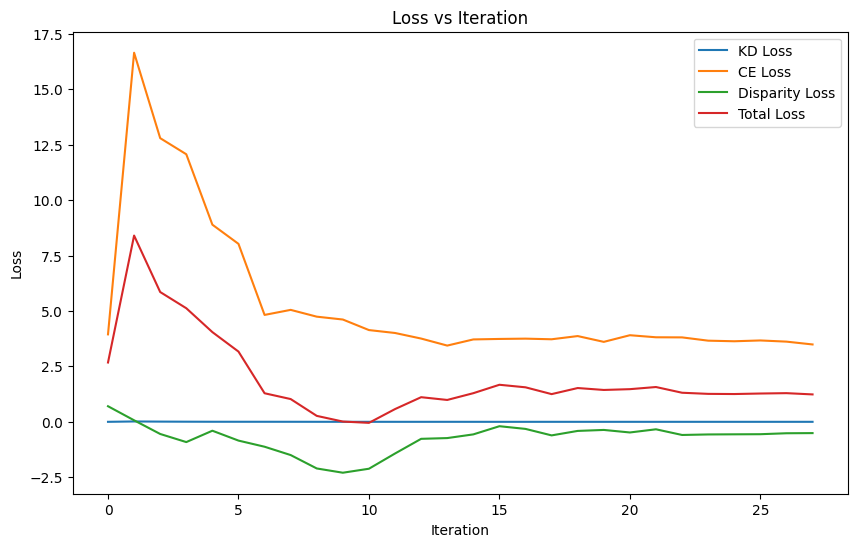

In [20]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Update the total number of epochs to include fine-tuning epochs
total_epochs = num_epochs + fine_tune_epochs

# Lists to store loss values
kd_loss_values = []
ce_loss_values = []
disparity_loss_values = []
total_loss_values = []

# Training loop
for epoch in range(total_epochs):
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{total_epochs}')
    # Change learning rate for fine-tuning phase
    if epoch == num_epochs:
        for param_group in optimizer_student.param_groups:
            param_group['lr'] = fine_tune_learning_rate
        for param_group in optimizer_teacher.param_groups:
            param_group['lr'] = fine_tune_learning_rate
        print(f'Starting fine-tuning with learning rate: {fine_tune_learning_rate}')

    student_model.train()
    teacher_model.train()
    for images, labels, annotations in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        # Forward pass
        teacher_outputs = teacher_model(images).to(device)
        student_outputs = student_model(images).to(device)

        # Calculate additional metrics including recall
        y_true = labels.cpu().numpy()
        y_pred_student = torch.argmax(student_outputs, dim=1).cpu().numpy()
        y_pred_teacher = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        
        # Calculate additional metrics including recall
        recall_student = recall_score(y_true, y_pred_student, average='weighted', zero_division=0)
        recall_teacher = recall_score(y_true, y_pred_teacher, average='weighted', zero_division=0)

        # Update recall values
        for attr in attributes:
            for concept in concepts:
                # Check if the sample belongs to the specified attribute and concept
                attr_indices = np.where(annotations[:, attr_idx[attr]].cpu().numpy() == 1)[0]  # Get indices where attribute is 1
                concept_indices = np.where(labels.cpu().numpy() == class_to_idx[concept])[0]  # Get indices where concept matches
                common_indices = np.intersect1d(attr_indices, concept_indices)  # Common indices
                if common_indices.size > 0:
                    teacher_recall_values[attr][concept].append(recall_teacher)
                    student_recall_values[attr][concept].append(recall_student)

        # Calculate the Knowledge Distillation loss and Cross Entropy loss
        kd_loss = criterion_student(
            F.log_softmax(student_outputs / temperature, dim=1),  # Apply temperature scaling
            F.softmax(teacher_outputs / temperature, dim=1)  # Apply temperature scaling
        )
        ce_loss = criterion_teacher(student_outputs, labels)
        
        # Append the loss values for plotting
        kd_loss_values.append(kd_loss.item())
        ce_loss_values.append(ce_loss.item())
    
        # Calculate the disparity for each attribute and concept
        disparity_loss_sum = 0  # Initialize a variable to sum the disparity losses
        for attr in attributes:
            for concept in concepts:
                # Check if the recall values lists are not empty before computing the mean
                if teacher_recall_values[attr][concept] and student_recall_values[attr][concept]:
                    teacher_recall = np.mean(teacher_recall_values[attr][concept])
                    student_recall = np.mean(student_recall_values[attr][concept])
                    disparity = teacher_recall - student_recall
                    disparity_tensor = torch.tensor(disparity, dtype=torch.float32).to(device)  # Convert disparity to a PyTorch tensor
                    disparity_loss_sum += disparity_weight * disparity_tensor  # Sum the disparity losses

        if torch.isnan(disparity_loss_sum):
            disparity_loss_sum = torch.tensor(0.0, dtype=torch.float32).to(device)
                
        disparity_loss_values.append(disparity_loss_sum.item())
        # Combine the losses
        total_loss = alpha * kd_loss + (1 - alpha) * ce_loss + disparity_loss_sum

        # Append the total loss value for plotting
        total_loss_values.append(total_loss.item())

        # Perform the backward pass
        total_loss.backward()

        # Optimize the models
        optimizer_student.step()
        optimizer_teacher.step()

        # Zero the gradients after updating weights
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        print(f'KD Loss: {kd_loss.item()}')
        print(f'CE Loss: {ce_loss.item()}')
        print(f'Disparity Loss: {disparity_loss_sum.item()}')
        print(f'Total Loss: {total_loss.item()}')
        print(f'teacher_recall: {teacher_recall}, student_recall: {student_recall}')

        # print(f'Labels: {labels.cpu().numpy()}')
        # print(f'Student Predictions: {torch.argmax(student_outputs, dim=1).cpu().numpy()}')
        # print(f'Teacher Predictions: {torch.argmax(teacher_outputs, dim=1).cpu().numpy()}')
        # print(f'attr_indices: {attr_indices}')
        # print(f'concept_indices: {concept_indices}')
        # print(f'common_indices: {common_indices}')
        # print(f'Student Outputs: {student_outputs}')
        # print(f'Teacher Outputs: {teacher_outputs}')
        # print(f'annotations: {annotations}')
        # print(f'attr: {attr}, concept: {concept}')
        # print(f'attr_idx: {attr_idx}, class_to_idx: {class_to_idx}')
        # print(f'Size of common_indices: {common_indices.size}')
        # print(f'Manual Student Recall: {recall_score(y_true, y_pred_student, average="weighted", zero_division=0)}')
        # print(f'Manual Teacher Recall: {recall_score(y_true, y_pred_teacher, average="weighted", zero_division=0)}')

# Disable anomaly detection when done
torch.autograd.set_detect_anomaly(False)

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(kd_loss_values, label='KD Loss')
plt.plot(ce_loss_values, label='CE Loss')
plt.plot(disparity_loss_values, label='Disparity Loss')
plt.plot(total_loss_values, label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Iteration')
plt.show()


# Evaluate

In [21]:
def calculate_disparity(teacher_recall_values, student_recall_values):
    disparity_values = {}
    for attr in attributes:  # Ensure 'attributes' is defined and correctly formatted
        disparity_values[attr] = {}
        for concept in concepts:  # Ensure 'concepts' is defined and correctly formatted
            teacher_values = teacher_recall_values.get(attr, {}).get(concept, [])
            student_values = student_recall_values.get(attr, {}).get(concept, [])
            if teacher_values and student_values:  # Check non-empty lists
                disparity_values[attr][concept] = np.mean(
                    [teacher_val - student_val for teacher_val, student_val in zip(teacher_values, student_values)]
                )
            else:
                print(f"Missing values for attr: {attr}, concept: {concept}")  # Debugging print statement
    return disparity_values

In [ ]:
# Validation
student_model.eval()
teacher_model.eval()
val_loss_student = 0.0
val_predictions_student = []
val_targets_student = []

val_loss_teacher = 0.0
val_predictions_teacher = []
val_targets_teacher = []

start_time = time.time()

with torch.no_grad():
    for images, labels, annotations in val_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        student_outputs = student_model(images)
        teacher_outputs = teacher_model(images)

        # Calculate cross-entropy loss for validation
        student_loss = criterion_teacher(student_outputs, labels)
        teacher_loss = criterion_teacher(teacher_outputs, labels)

        val_loss_student += student_loss.item()
        val_loss_teacher += teacher_loss.item()

        # Store predictions and ground truth labels for metrics
        val_predictions_student.extend(torch.argmax(student_outputs, dim=1).cpu().numpy())
        val_predictions_teacher.extend(torch.argmax(teacher_outputs, dim=1).cpu().numpy())

        val_targets_student.extend(labels.cpu().numpy())
        val_targets_teacher.extend(labels.cpu().numpy())

end_time = time.time()  # End time measurement
inference_time_student = (end_time - start_time) / len(val_loader)
inference_time_teacher = (end_time - start_time) / len(val_loader)

val_disparity_values = calculate_disparity(teacher_recall_values, student_recall_values)

# Calculate the average disparity
avg_disparity = np.mean(
    [value for attr_dict in val_disparity_values.values()
     for concept_dict in attr_dict.values()
     for value in (concept_dict.values() if isinstance(concept_dict, dict) else [concept_dict])])


# Calculate validation accuracy and recall
val_accuracy_student = accuracy_score(val_targets_student, val_predictions_student)
val_accuracy_teacher = accuracy_score(val_targets_teacher, val_predictions_teacher)
val_recall_student = recall_score(val_targets_student, val_predictions_student, average='weighted')
val_recall_teacher = recall_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_precision_student = precision_score(val_targets_student, val_predictions_student, average='weighted')
val_precision_teacher = precision_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_f1_student = f1_score(val_targets_student, val_predictions_student, average='weighted')
val_f1_teacher = f1_score(val_targets_teacher, val_predictions_teacher, average='weighted')

# Get model size (number of parameters)
model_size_student = sum(p.numel() for p in student_model.parameters())
model_size_teacher = sum(p.numel() for p in teacher_model.parameters())

val_metrics_teacher = calculate_metrics(val_targets_teacher, val_predictions_teacher)
val_metrics_student = calculate_metrics(val_targets_student, val_predictions_student)
  
# Gather metrics in dictionaries for easier plotting
teacher_metrics = {
    'Accuracy': val_metrics_teacher[0],
    'Precision': val_metrics_teacher[1],
    'Recall': val_metrics_teacher[2],
    'F1 Score': val_metrics_teacher[3],
    'Disparity': avg_disparity,  # Corrected here
    'Model Size': model_size_teacher,
    'Inference Time': inference_time_teacher
}

student_metrics = {
    'Accuracy': val_metrics_student[0],
    'Precision': val_metrics_student[1],
    'Recall': val_metrics_student[2],
    'F1 Score': val_metrics_student[3],
    'Disparity': avg_disparity,  # Corrected here
    'Model Size': model_size_student,
    'Inference Time': inference_time_student
}

# Define labels for plotting
size_labels = ['Model Size']
time_labels = ['Inference Time']
other_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Disparity']  # Define labels for other metrics

# Extract values for each type of metric
size_teacher_values = [teacher_metrics['Model Size']]
size_student_values = [student_metrics['Model Size']]

time_teacher_values = [teacher_metrics['Inference Time']]
time_student_values = [student_metrics['Inference Time']]

other_teacher_values = [teacher_metrics[key] for key in other_labels]
other_student_values = [student_metrics[key] for key in other_labels]

# Print validation results for this epoch
print(f'Epoch [{epoch+1}/{num_epochs}]'
      f' Teacher Loss: {val_loss_teacher / len(val_loader):.4f}'
      f' Teacher Accuracy: {val_accuracy_teacher:.4f}'
      f' Teacher Recall: {val_recall_teacher:.4f}'
      f' Student Loss: {val_loss_student / len(val_loader):.4f}'
      f' Student Accuracy: {val_accuracy_student:.4f}'
      f' Student Recall: {val_recall_student:.4f}')

# Print disparity for validation
for attr in attributes:
    for concept in concepts:
        # Handle potential missing values with a default of NaN or another value of your choice
        print(f'Validation Disparity for {attr} and {concept}: {val_disparity_values.get(attr, {}).get(concept, np.nan):.4f}')


In [ ]:
def create_plot(labels, teacher_values, student_values, title):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Function to create a bar plot specifically for disparity
def plot_disparity(title):
    labels = ['Disparity']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [teacher_metrics['Disparity']], width, label='Teacher')
    rects2 = ax.bar(x + width/2, [student_metrics['Disparity']], width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Create plots
create_plot(size_labels, size_teacher_values, size_student_values, 'Model Size Comparison')
create_plot(time_labels, time_teacher_values, time_student_values, 'Inference Time Comparison')
plot_disparity('Disparity Comparison')
create_plot(other_labels[:-1], other_teacher_values[:-1], other_student_values[:-1], 'Other Metrics Comparison')  

In [ ]:
torch.save(student_model.state_dict(), 'student_model2.pth')
torch.save(teacher_model.state_dict(), 'teacher_model2.pth')

In [ ]:
accuracy_score(val_targets_student, val_predictions_student)

In [ ]:
accuracy_score(val_targets_teacher, val_predictions_teacher)

In [ ]:
val_loss_student / len(val_loader)

In [ ]:
val_loss_teacher / len(val_loader)